In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.lstm_vae import *
import torch
import random
from pathlib import Path
from config import *
from load_utils import *
from lstm_utils import *

import numpy as np
import platform
import json

architecture='lstm_vae'

In [2]:
exp_dict = exp_name_folders(path =esa_exploration, architecture=architecture)
for k in exp_dict.keys():
    print('num selection:{} - exp name:{}'.format(k, exp_dict[k]))

FileNotFoundError: [Errno 2] No such file or directory: '/srv/penny/FIORIRE/time_series_anomaly_detection/model_results/esa_exploration/lstm_vae/'

In [3]:
select_exp = '0'
added_path = exp_dict[select_exp]
model_results_path = esa_exploration + '{}/{}'.format(architecture, added_path)
print('selected experiment:', added_path)

selected experiment: 4_wheels_system_03-29-23:12:58:01_lstm_vae_sl16


In [4]:
files = os.listdir(model_results_path)
model_list, summary = find_models(files, model_results_path)

summary path: /davinci-1/home/morellir/artificial_intelligence/repos/time_series_anomaly_detection/model_results/esa_exploration/lstm_vae/4_wheels_system_03-29-23:12:58:01_lstm_vae_sl16/summary.csv


In [6]:
summary.drop(columns = ['train_loss']).reset_index().head(10)

,index,Unnamed: 0,name,parameters_number,val_loss,mse_val_loss
0,15,5,"trainLSTMVAE_92f62_00005_5_batch_size=50,embed...",431240,0.018513,0.017830
1,14,12,"trainLSTMVAE_92f62_00001_1_batch_size=200,embe...",588896,0.314505,0.306125
2,13,11,"trainLSTMVAE_92f62_00007_7_batch_size=50,embed...",411940,0.317412,0.315107
3,12,14,"trainLSTMVAE_92f62_00015_15_batch_size=200,emb...",67896,0.370486,0.365391
4,11,2,"trainLSTMVAE_92f62_00006_6_batch_size=500,embe...",71776,0.377352,0.366573
5,10,9,"trainLSTMVAE_92f62_00009_9_batch_size=500,embe...",125144,0.379341,0.372207
6,9,13,"trainLSTMVAE_92f62_00012_12_batch_size=100,emb...",1424,0.525059,0.523482
7,8,15,"trainLSTMVAE_92f62_00014_14_batch_size=50,embe...",936,0.683267,0.681274
8,7,4,"trainLSTMVAE_92f62_00011_11_batch_size=500,emb...",2740,1.028742,0.985237
9,6,0,"trainLSTMVAE_92f62_00010_10_batch_size=1000,em...",250424,1.044554,1.032519


In [6]:
rank = 0
model_name_path = select_by_rank(rank, model_results_path, summary)
model_name = summary.name.iloc[rank]
f = open(os.path.join(model_results_path, '/'.join(model_name_path.split('/')[:-2]), 'params.json'))
print('hyper-parameters')
print(json.load(f))

hyper-parameters
{'batch_size': 50, 'embedding_dim': 64, 'epochs': 500, 'kld_factor': 0.01, 'latent_dim': 60, 'lr': 0.0006, 'lr_patience': 7, 'n_layers_1': 1, 'n_layers_2': 2, 'recon_loss_type': '"custom"', 'seq_in_length': 16}


In [7]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

In [8]:
checkpoint  = torch.load(os.path.join(model_results_path, model_name_path), map_location=device)
params_conf = checkpoint['param_conf']
cfg = checkpoint['cfg']

In [9]:
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
transform = None
df_train, df_test, train_iter, test_iter = \
read_dataset(dataset_name=dataset_name, scaled=params_conf['scaled'], cols=checkpoint['cfg']['dataset']['columns'],
columns_subset=cfg['dataset']['columns_subset'], dataset_subset=cfg['dataset']['dataset_subset']
, sequence_length=params_conf['sequence_length'],out_window=params_conf['sequence_length'], 
train_val_split=cfg['dataset']['train_val_split'], batch_size=params_conf['batch_size'], transform=transform)    

In [10]:
num_batch=10
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))
x, shift = unrolling_batches(num_batch, test_iter, sequence_length=params_conf['sequence_length']
                             , cols=cfg['dataset']['columns'])

time horizon 160
random shift 44868


In [11]:
model = LSTM_VAE(seq_in=params_conf['sequence_length'],seq_out=params_conf['out_window'],
        no_features=params_conf['n_features'], output_size=params_conf['n_features'],
        embedding_dim=params_conf['embedding_dim'], latent_dim=params_conf['latent_dim'],
        Nf_lognorm=params_conf['n_features'], Nf_binomial=0, n_layers_1=params_conf['n_layers_1'],
        n_layers_2=params_conf['n_layers_2'], recon_loss_type=params_conf['recon_loss_type'])

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()
par_nums = count_parameters(model)
print('parameters number', count_parameters(model))

LSTM_VAE(
  (encoder): Encoder_vae(
    (LSTMenc): LSTM(16, 128, batch_first=True)
    (LSTM1): LSTM(128, 64, num_layers=2, batch_first=True)
    (mu): Linear(in_features=64, out_features=60, bias=True)
    (log_var): Linear(in_features=64, out_features=60, bias=True)
  )
  (decoder): Decoder_vae(
    (act2): InverseSquareRootLinearUnit()
    (act3): ClippedTanh()
    (LSTMdec): LSTM(60, 64, batch_first=True)
    (LSTM1): LSTM(64, 128, num_layers=2, batch_first=True)
    (par1): Linear(in_features=128, out_features=16, bias=True)
  )
)
parameters number 431240


In [20]:
if params_conf['recon_loss_type']=='custom':
    x, mu, log_var, pars  = model(x.to(device))
    yo = pars[0]
else:
    x, mu, log_var, yo  = model(x.to(device))

In [22]:
path = './figure_results/{}/{}/'.format(model_results_path, shift)
par_nums=count_parameters(model)
print(path)
save = False

./figure_results//davinci-1/home/morellir/artificial_intelligence/repos/time_series_anomaly_detection/model_results/esa_exploration/lstm_vae/4_wheels_system_03-29-23:12:58:01_lstm_vae_sl16/44868/


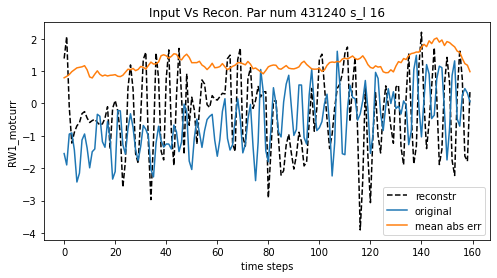

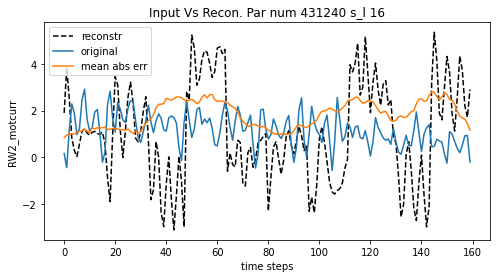

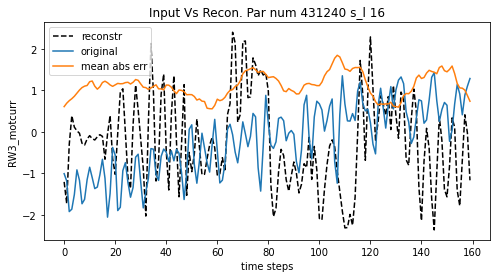

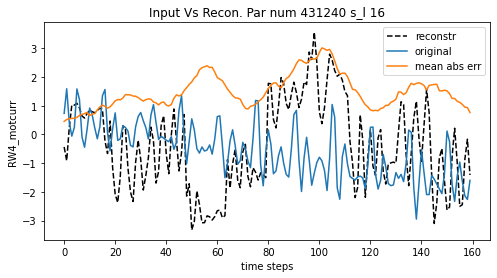

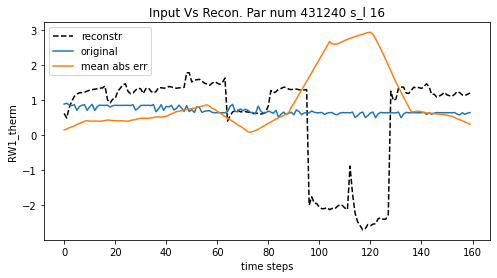

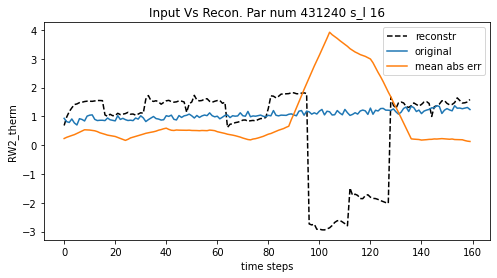

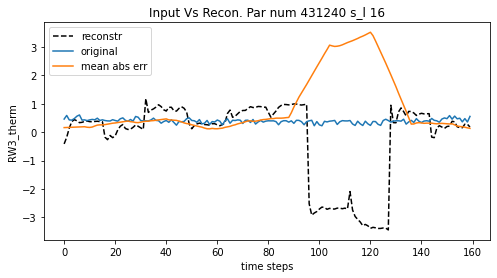

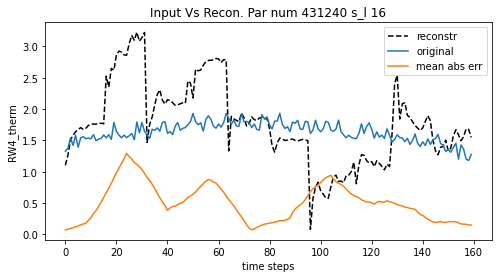

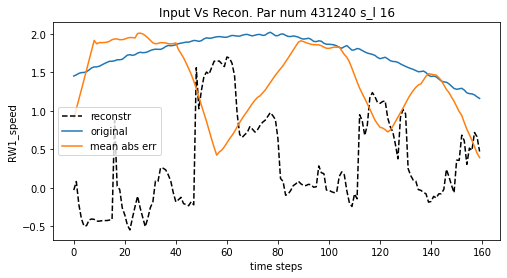

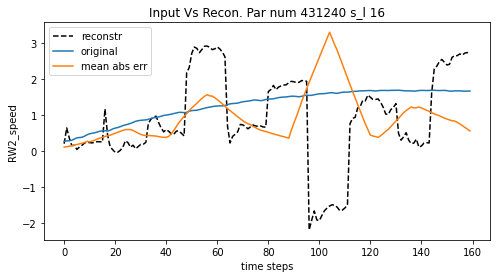

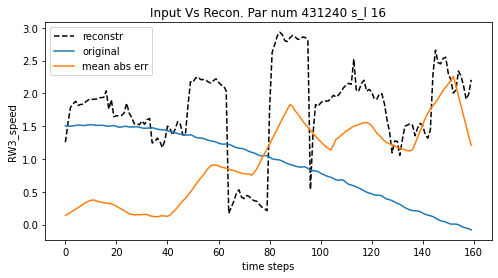

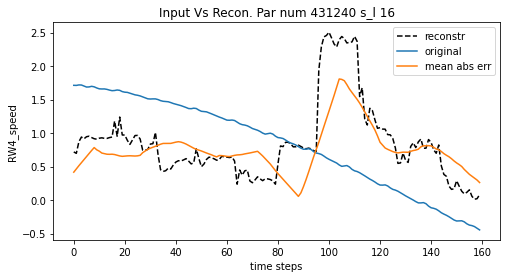

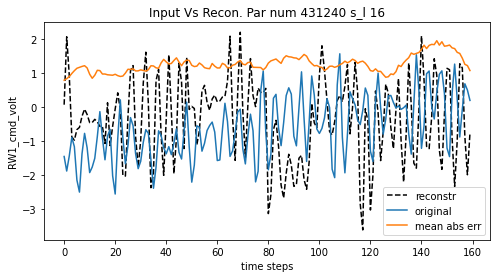

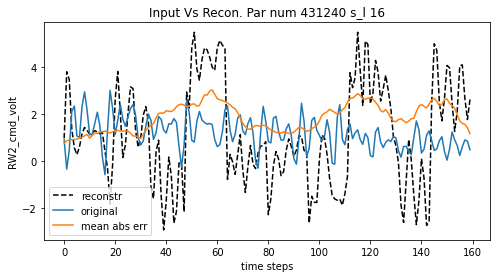

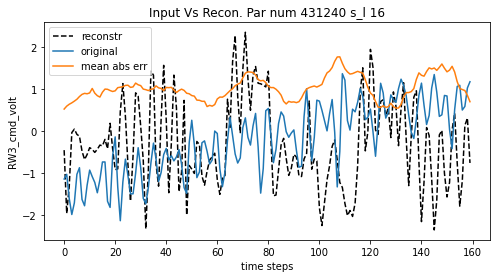

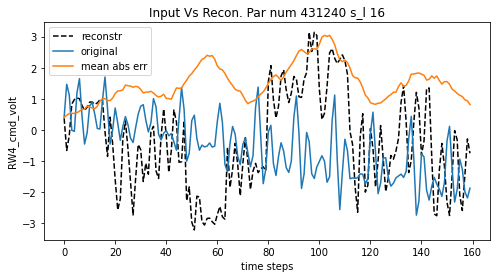

In [23]:
show_results(x,yo,checkpoint['cfg']['dataset']['columns'],
    model_name,params_conf,
    par_nums,shift,num_batch,
    architecture='lstm_ae',
    save=False)